In [28]:
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
from software.backtester import run_back_test
from software.plotter import plot_bollinger_bands, plot_ema_and_sma, plot_rsi, plot_atr, plot_signals
from software.strategy import Strategy
from software.tasks import execute_trades
from software.analysis import evaluate_performance

%matplotlib inline
sns.set_style('darkgrid')

ticker = "BTC-USD"
start_date = "2024-10-01 12:00:00"
end_date = "2024-11-03 20:30:00"
interval = "1h"

sma_period=5
ema_period=20
rsi_period=7
bbands_period=20
atr_period=14

initial_cash = 1000
transaction_cost = 0.001
leverage=1
slippage_pct=0.0005
risk_per_trade=0.02

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
processed_data = process_data(
    data,
    sma_period=sma_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    bbands_period=bbands_period,
    atr_period=atr_period,
)

strategy = Strategy(
    ema_sma_threshold=0,
    rsi_long_threshold=40,
    rsi_short_threshold=60,
    bb_threshold=0,
)


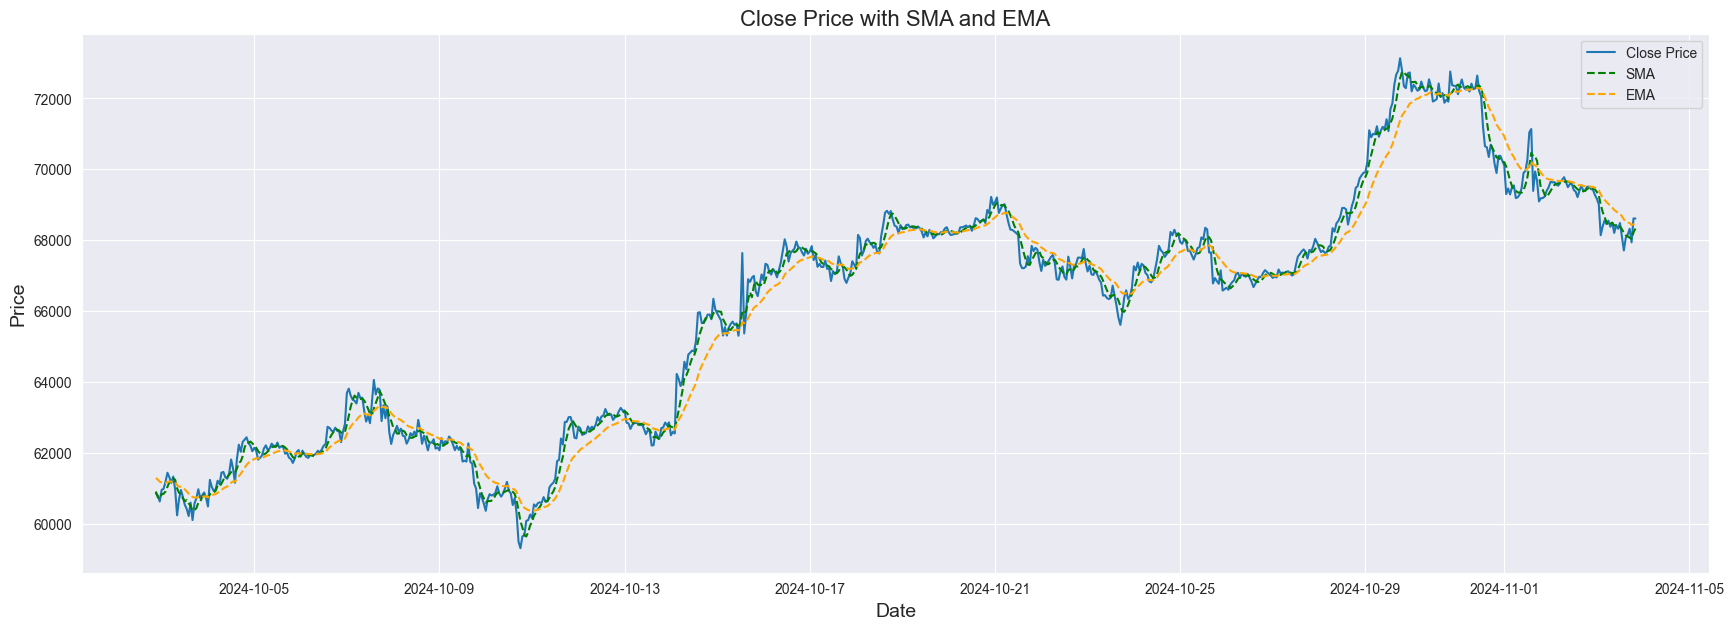

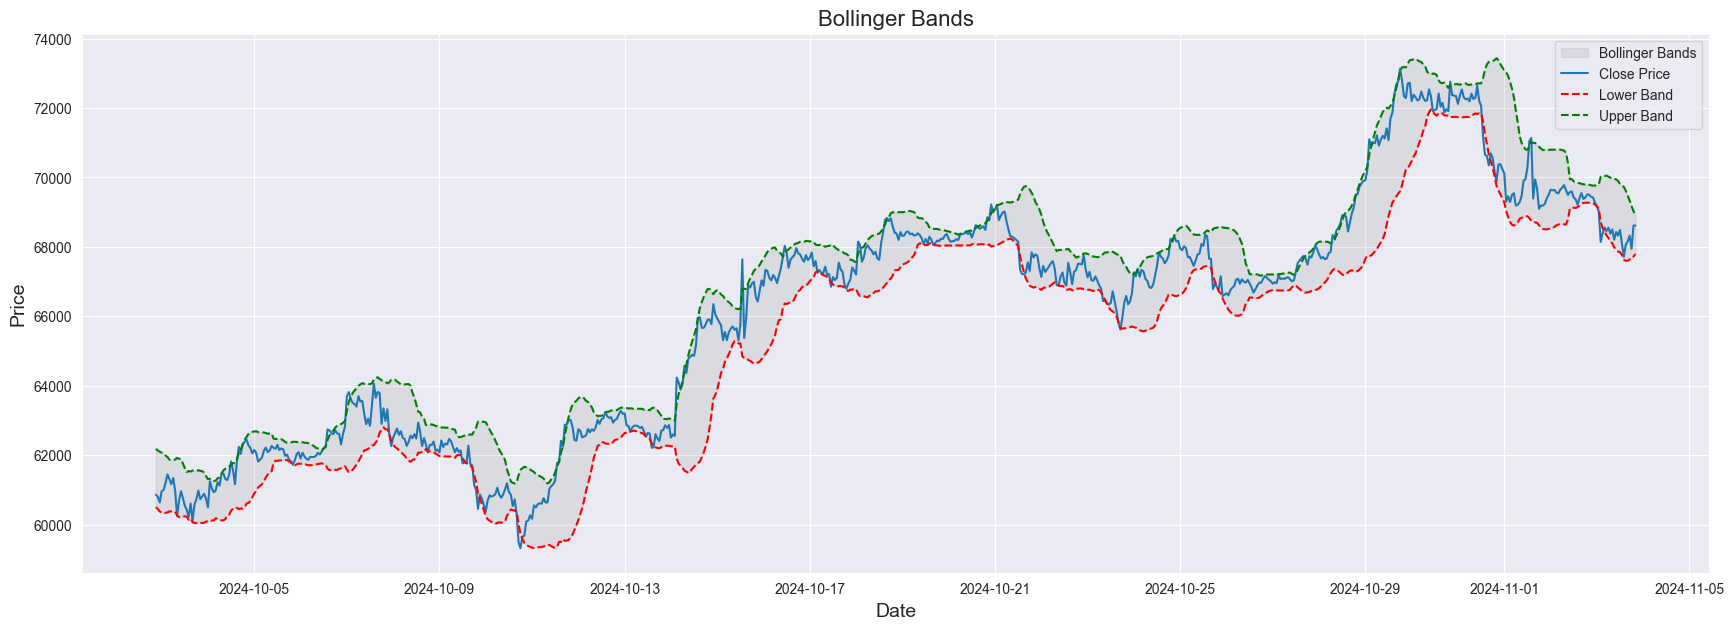

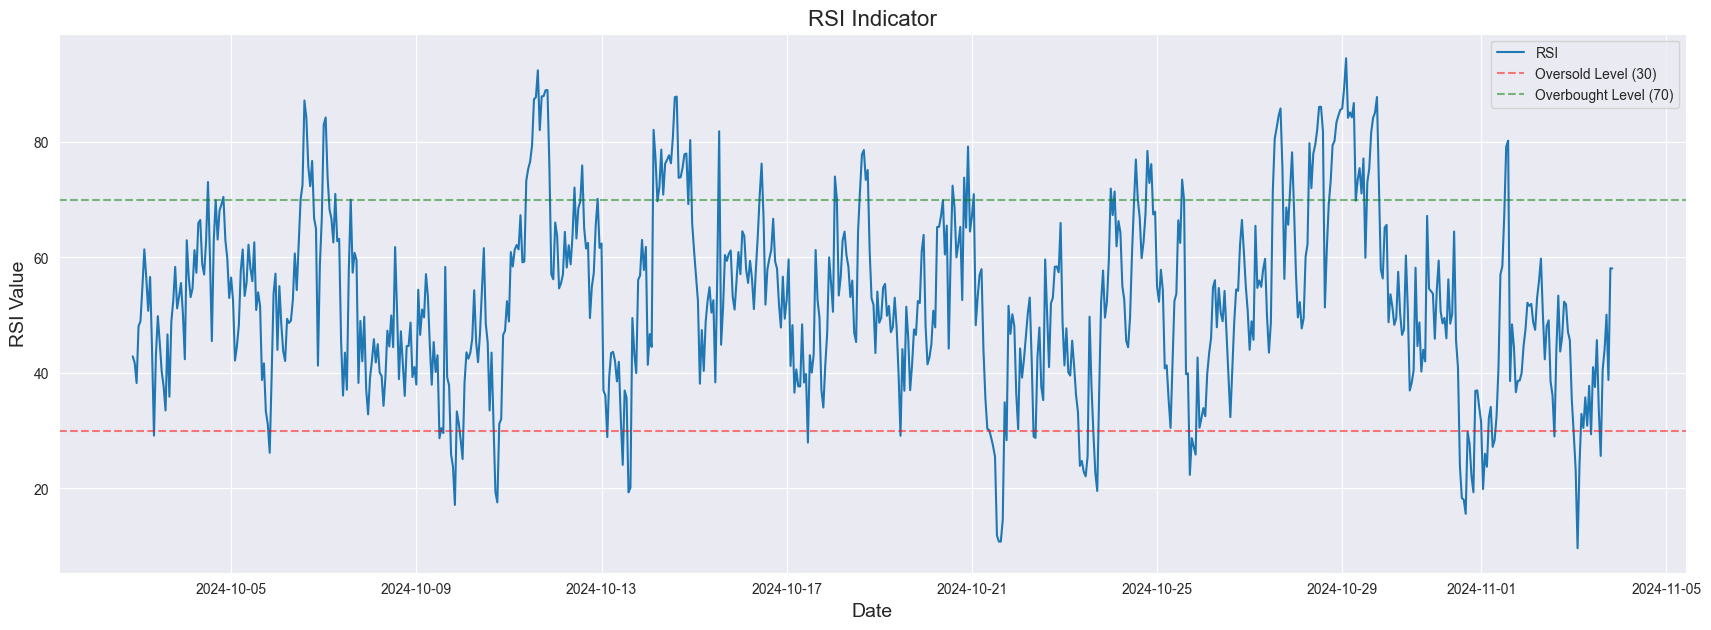

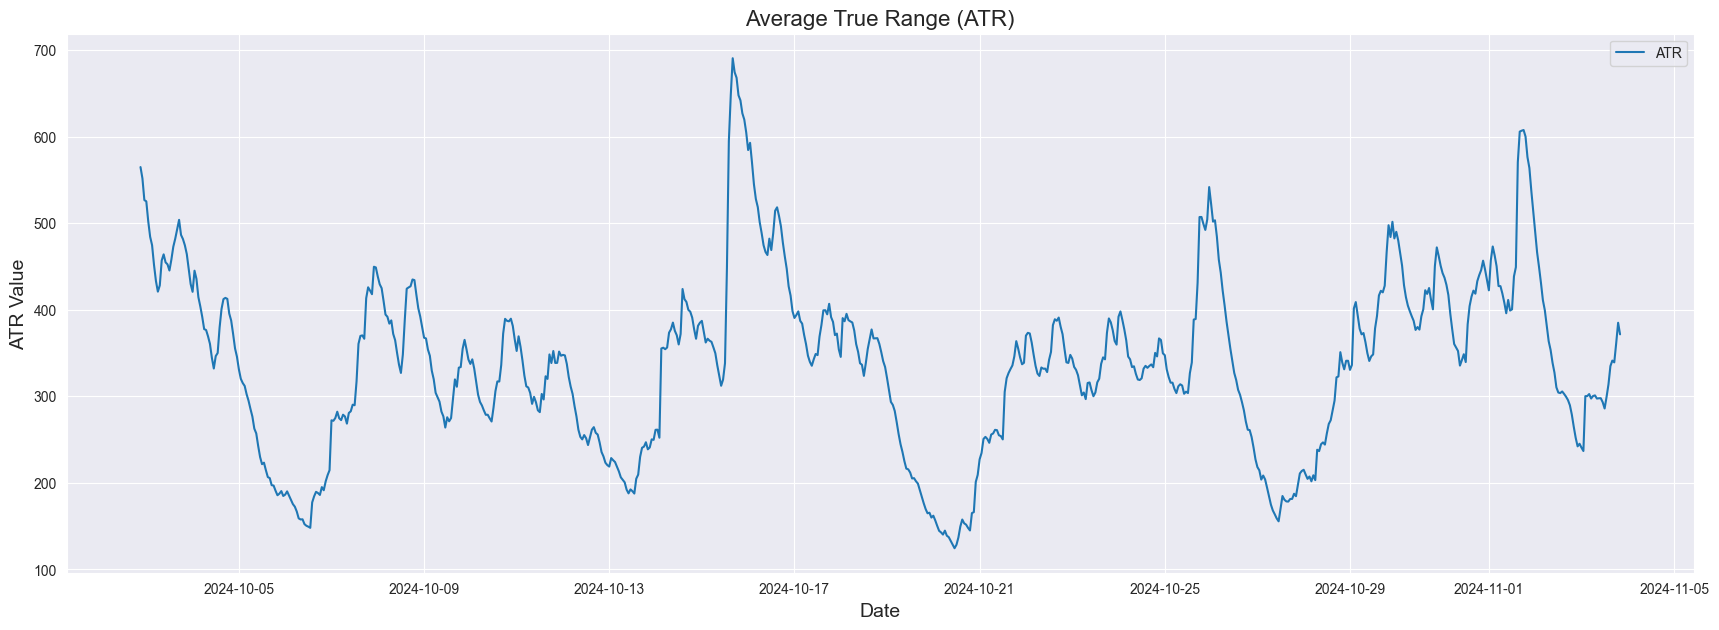

In [29]:
plot_ema_and_sma(processed_data)
plot_bollinger_bands(processed_data)
plot_rsi(processed_data)
plot_atr(processed_data)

In [30]:
data_with_signals = strategy.generate_buy_signals(processed_data)

Signals : [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, -1, -1, 0, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, 0, 0, 0, -1, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0

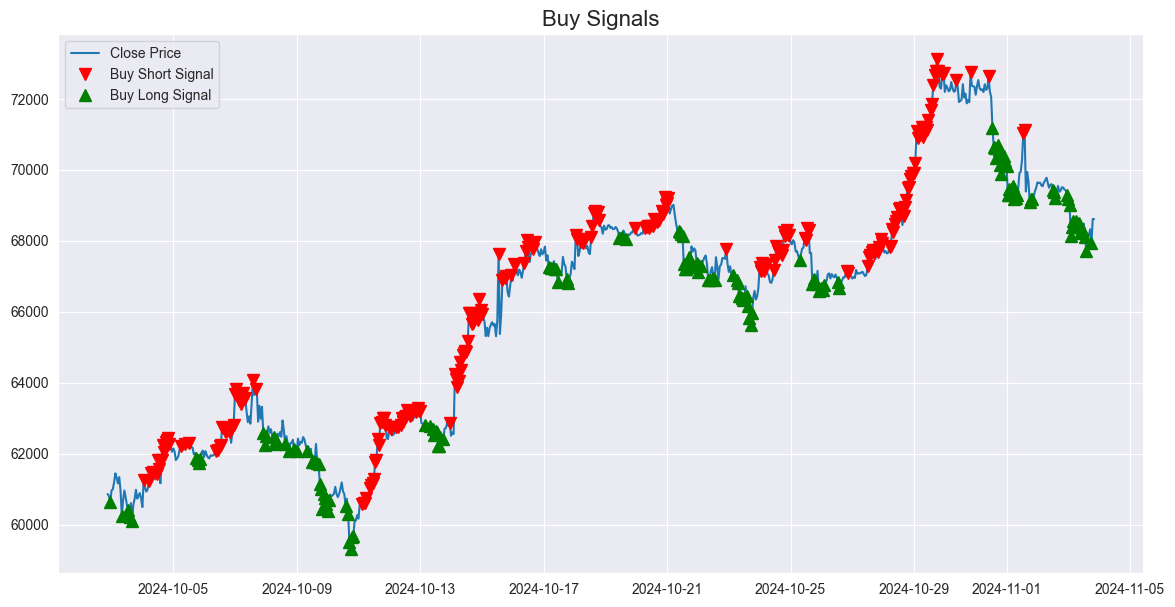

In [31]:
print("Signals :", data_with_signals["Signal"].tolist())
plot_signals(processed_data)

In [32]:
# transactions, equity_curve, dates = execute_trades(
#     data=data_with_signals,
#     initial_cash=initial_cash,
#     transaction_cost=transaction_cost,
#     leverage=leverage,
#     slippage_pct=slippage_pct,
#     risk_per_trade=risk_per_trade,
# )

from software.executor import TradingExecutor
from tqdm import tqdm

executor = TradingExecutor(
    initial_cash=initial_cash,
    transaction_cost=transaction_cost,
    leverage=leverage,
    slippage_pct=slippage_pct,
    risk_per_trade=risk_per_trade,
)

transactions = []
equity_curve = []
dates = []

print("Executor :", executor.__dict__)

Executor : {'cash': 1000, 'transaction_cost': 0.001, 'leverage': 1, 'slippage_pct': 0.0005, 'risk_per_trade': 0.02, 'positions': [], 'history': []}


In [33]:
for index, row in tqdm(
    data_with_signals.iterrows(),
    total=len(data_with_signals),
    desc="Executing trades",
):
    signal = row["Signal"]
    price = row["Close"]
    atr_stop_loss = row["ATR"] * 2

    date = index

    # print(f"Signal: {signal}, Price: {price}, ATR Stop Loss: {atr_stop_loss}, Date: {date}")

    executor.execute_signal(
        signal,
        price,
        atr_stop_loss,
        date,
    )
    executor.update_positions(price, date, atr_stop_loss)

    if executor.history and (
        not transactions or executor.history[-1] != transactions[-1]
    ):
        last_transaction = executor.history[-1]
        transactions.append(last_transaction)

    total_value = executor.get_total_portfolio_value(price)
    equity_curve.append(total_value)
    dates.append(date)

Executing trades: 100%|████████████████████| 768/768 [00:00<00:00, 49948.45it/s]

Size in USDT:  559.9883988178331
Amount:  0.00922985569576011 BTC/USDT
======= Position opened at:  60671.414296874995 =======
Size in USDT:  682.8743624833146
Amount:  0.010962364659095825 BTC/USDT
======= Position opened at:  62292.615117187495 =======
Size in USDT:  879.5263894027461
Amount:  0.014410286226872966 BTC/USDT
======= Position opened at:  61034.623154296874 =======
Size in USDT:  765.5268759695525
Amount:  0.012858094245323297 BTC/USDT
======= Position opened at:  59536.57372265625 =======
Size in USDT:  712.8577625432372
Amount:  0.01145021405499242 BTC/USDT
======= Position opened at:  62257.15599023437 =======
Stop loss price:  68284.60130191456
Size in USDT:  1008.6939189354486
Amount:  0.015084341155468967 BTC/USDT
======= Position opened at:  66870.266890625 =======
Stop loss price:  69512.16276735989
Size in USDT:  976.8571453075917
Amount:  0.014209775683858217 BTC/USDT
======= Position opened at:  68745.43040234376 =======
Stop loss price:  69094.71723068006
Siz

In [34]:
print("Transactions :", transactions)
print("Equity curve :", equity_curve)
print("Dates :", dates)

Transactions : [{'action': 'open', 'position_type': 'long', 'price': 60671.414296874995, 'amount': 0.00922985569576011, 'date': Timestamp('2024-10-02 23:00:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'long', 'price': 62624.085457031244, 'amount': 0.00922985569576011, 'date': Timestamp('2024-10-07 22:00:00+0000', tz='UTC'), 'pnl': 18.02287302951466}, {'action': 'open', 'position_type': 'long', 'price': 62292.615117187495, 'amount': 0.010962364659095825, 'date': Timestamp('2024-10-07 23:00:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'long', 'price': 61176.291609374995, 'amount': 0.010962364659095825, 'date': Timestamp('2024-10-09 18:00:00+0000', tz='UTC'), 'pnl': -12.237545370161632}, {'action': 'open', 'position_type': 'long', 'price': 61034.623154296874, 'amount': 0.014410286226872966, 'date': Timestamp('2024-10-09 19:00:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'long', 'price': 60337.21212304687, 'amount': 0.014410286226872966, 'date': Ti

In [35]:
performance_metrics = evaluate_performance(
    transactions, equity_curve, initial_cash
)

final_portfolio_value = equity_curve[-1]
total_profit = final_portfolio_value - initial_cash
print(f"Total Profit: ${total_profit:.2f}")

Total Profit: $153.99


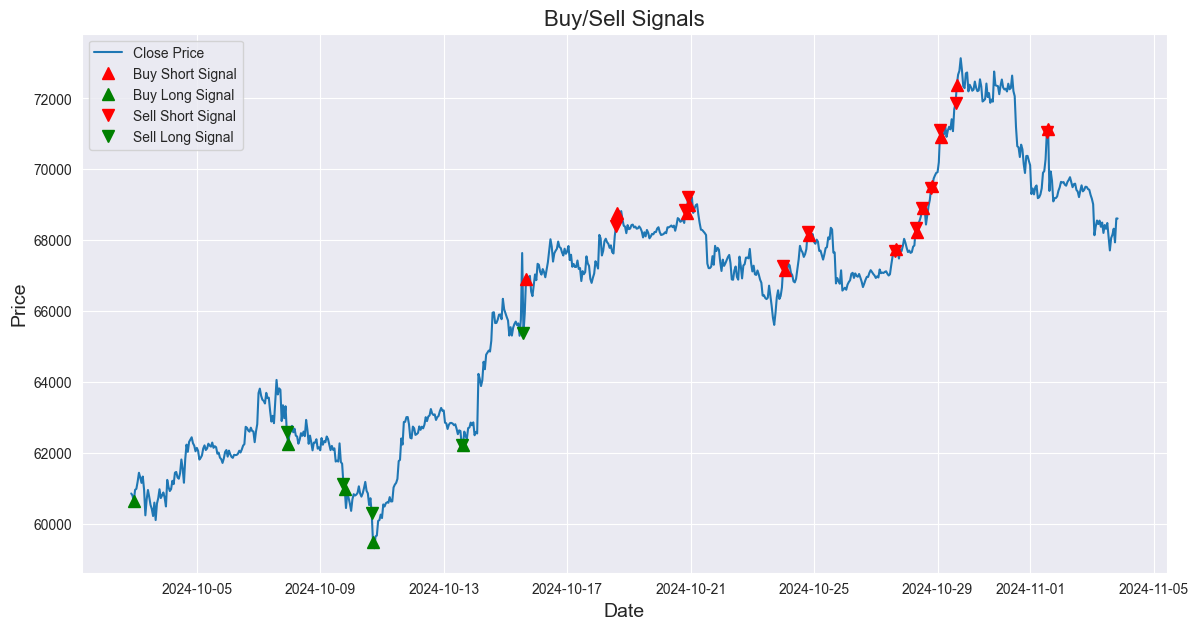

In [36]:
from software.plotter import plot_trades

plot_trades(price_data=processed_data, transactions=transactions)

Have to add update functionality for SL or TP. With trailing stop loss, it will be a good strategy.